In [111]:
import numpy as np
import torch.nn as nn
import torch, torchvision

import matplotlib.pyplot as plt

from Analog2SpikeDataset import SpikeDataset
from torch.utils.data import DataLoader

In [112]:
torch.manual_seed(0)

In [113]:
if torch.cuda.is_available():               # check GPU availability
    device = torch.device('cuda')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA RTX A4000


## Simulation Parameters

In [114]:
batch_size = 256
nb_steps = 100
lr = 2e-4
epochs = 30
root = 'datasets'

## Training Data

In [115]:
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

train_spks = SpikeDataset(train_dataset, num_steps=nb_steps)
test_spks = SpikeDataset(test_dataset, num_steps=nb_steps)

train_loader = DataLoader(train_spks, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_spks, batch_size=batch_size, shuffle=True, drop_last=True)

In [116]:
sample = train_spks[1]
x_ = sample[0]
y_ = sample[1]

x_ = np.array(x_.tolist())
y_ = np.array(y_.tolist())

#train_spks.plot_sample(idx=1, save=True)

## Neuron Model

In [117]:
from SurrogateGradient import SpkSurrogateGradFunction

class LIFlayer(nn.Module):
    def __init__(self, tau_mem=10e-3, tau_syn=5e-3, threshold=1.0, t_step=1e-3, output=False):
        super().__init__()

        self.tau_mem = tau_mem
        self.tau_syn = tau_syn
        self.threshold = threshold
        self.t_step = t_step
        self.output = output

        self.beta = np.float64(np.exp(-self.t_step/self.tau_mem))
        self.alpha = np.float64(np.exp(-self.t_step/self.tau_syn))

        self.spike_fn = SpkSurrogateGradFunction.apply
        
        self.forwarded = False

    def reset_mem(self):
        self.forwarded = False
    
    def forward(self, x, k):

        if not hasattr(self, 'mem') or not self.forwarded:
            self.mem = torch.zeros_like(x, requires_grad=True)
            self.syn = torch.zeros_like(x, requires_grad=True)
            self.forwarded = True

        spk = self.spike_fn(self.mem, self.threshold, k)
        rst = spk.detach()

        self.syn = self.alpha*self.syn + x
        
        if self.output:
            self.mem = (self.beta*self.mem + self.syn)
        else:
            self.mem = (self.beta*self.mem + self.syn)*(1.0 - rst)

        return spk, self.mem

## Spiking CONV Network

In [118]:
class SCNN(nn.Module):
    def __init__(self, device, input_size=(28,28), nb_fc_units=100, nb_outputs=10):
        super().__init__()

        self.k = np.float64(100.0)

        # --- 1st conv layer
        self.k1 = 2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=self.k1, stride=1, padding=0, bias=False)
        self.convlif1 = LIFlayer()
        self.ws1 = 7*(1.0-self.convlif1.beta)
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=self.ws1/np.sqrt(self.k1*self.k1))

        outs1 = SCNN.conv_output_size(input_size, conv_st=1, conv_pd=0, conv_ks=self.k1)

        # --- 2nd conv layer
        self.k2 = 2
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=self.k2, stride=1, padding=0, bias=False)
        self.convlif2 = LIFlayer()
        self.ws2 = 7*(1.0-self.convlif2.beta)
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=self.ws2/np.sqrt(self.k2*self.k2))

        outs2 = SCNN.conv_output_size(outs1, conv_st=1, conv_pd=0, conv_ks=self.k2)

        nb_fc = 3*outs2[0]*outs2[1]
        
        print(outs1)
        print(outs2)
        print(nb_fc)

        # --- FC layers
        self.fc1lif = LIFlayer()
        self.fc2lif = LIFlayer(output=True)

        # --- Weight matrix between last Conv layer and firt FC layer
        self.w_conv_fc = torch.empty((nb_fc, nb_fc_units), device=device, dtype=torch.float, requires_grad=True)
        self.ws3 = 7*(1.0-self.fc1lif.beta)
        torch.nn.init.normal_(self.w_conv_fc, mean=0.0, std=self.ws3/np.sqrt(nb_fc))

        # --- Weight matrix between FC layer and output layer
        self.w_fc_out = torch.empty((nb_fc_units, nb_outputs), device=device, dtype=torch.float, requires_grad=True)
        self.ws4 = 7*(1.0-self.fc2lif.beta)
        torch.nn.init.normal_(self.w_fc_out, mean=0.0, std=self.ws4/np.sqrt(nb_fc_units))

    def forward(self, x):
        batch_size = x.size(0)

        # --- 1st conv layer
        out = self.conv1(x)
        out, mem1 = self.convlif1(out, self.k)

        # --- 2nd conv layer
        out = self.conv2(out)
        out, mem2 = self.convlif2(out, self.k)

        # --- FC layer 1
        _flat = out.view(batch_size, -1)
        _inp_fc = torch.einsum('ij,jk->ik', (_flat, self.w_conv_fc))
        out, mem3 = self.fc1lif(_inp_fc, self.k)

        # --- FC layer 2
        _inp_o = torch.einsum('ij,jk->ik', (out, self.w_fc_out))
        out, mem4 = self.fc2lif(_inp_o, self.k)

        return out, mem4
    
    def reset_states(self):
        self.convlif1.reset_mem()
        self.convlif2.reset_mem()
        self.fc1lif.reset_mem()
        self.fc2lif.reset_mem()
    
    @staticmethod
    def model_forward(model, data, nb_steps):
        spk_out_all = []
        mem_out_all = []
        model.reset_states()

        for step in range(nb_steps):
            spk_out, mem_out = model.forward(data[:, step:step+1, :, :])

            spk_out_all.append(spk_out)
            mem_out_all.append(mem_out)

        return torch.stack(spk_out_all, dim=1), torch.stack(mem_out_all, dim=1)

    @staticmethod
    def conv_output_size(input_size, conv_st, conv_pd, conv_ks):
        conv_output_size = [(size + 2 * conv_pd - conv_ks) // conv_st + 1 for size in input_size]
        return conv_output_size

In [119]:
model = SCNN(device=device).to(device)

[27, 27]
[26, 26]
2028


## Optimizer & Loss

In [120]:
params = [model.conv1.weight, model.conv2.weight, model.w_conv_fc, model.w_fc_out]
optimizer = torch.optim.Adam(params, lr=lr)

In [121]:
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

## Training Loop

In [122]:
loss_hist = []
model.train()

for e in range(epochs):
    local_loss = []
    
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        out_spks, out_mems = SCNN.model_forward(model, data, nb_steps)
        m, _ = torch.max(out_mems, 1)
        log_p_y = log_softmax_fn(m)

        # initialize the loss & sum over time
        loss_val = loss_fn(log_p_y, targets.long())

        # gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        local_loss.append(loss_val.item())
    
    mean_loss = np.mean(local_loss)
    print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
    loss_hist.append(mean_loss)

Epoch 1: loss=1.60962
Epoch 2: loss=1.31356
Epoch 3: loss=1.10556
Epoch 4: loss=0.83048
Epoch 5: loss=0.74322
Epoch 6: loss=0.70347
Epoch 7: loss=0.68100
Epoch 8: loss=0.66214
Epoch 9: loss=0.63213
Epoch 10: loss=0.60694
Epoch 11: loss=0.58173
Epoch 12: loss=0.57395
Epoch 13: loss=0.56702
Epoch 14: loss=0.56178
Epoch 15: loss=0.55981
Epoch 16: loss=0.55820
Epoch 17: loss=0.56765
Epoch 18: loss=0.59495
Epoch 19: loss=0.57255
Epoch 20: loss=0.54800
Epoch 21: loss=0.54384
Epoch 22: loss=0.54920
Epoch 23: loss=0.52674
Epoch 24: loss=0.51533
Epoch 25: loss=0.49989
Epoch 26: loss=0.48359
Epoch 27: loss=0.47237
Epoch 28: loss=0.46871
Epoch 29: loss=0.46323
Epoch 30: loss=0.45871


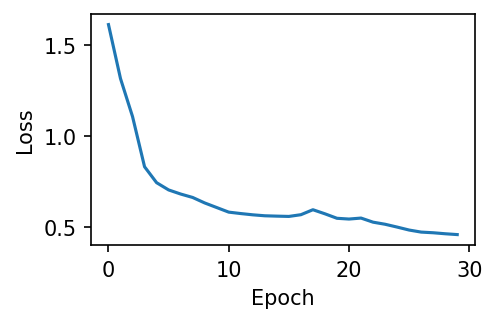

In [123]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Accuracy

In [124]:
accs = []
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()

    test_loader = iter(test_loader)

    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        out_spks, out_mems = SCNN.model_forward(model, data, nb_steps)

        m,_= torch.max(out_mems,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((targets==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

mean_acc = np.mean(accs)
print(f'test accuracy: {mean_acc}')

test accuracy: 0.8226161858974359


In [125]:
accs = []
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()

    train_loader = iter(train_loader)

    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        out_spks, out_mems = SCNN.model_forward(model, data, nb_steps)

        m,_= torch.max(out_mems,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((targets==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

mean_acc = np.mean(accs)
print(f'train accuracy: {mean_acc}')

train accuracy: 0.8368723290598291
